# MIMIC III Dataset - Data Preparation

The aim of this notebook is to describe how to access and preprocess the MIMIC III dataset. In particular, we will apply the CheXpert rules to this dataset in order to obtain weak labels and create $T$ and $Z$ matrices that can be further used for experiments within `knodle`.

## Data access and download

The MIMIC III dataset is freely accessible from the PhysioNet Database: https://physionet.org/content/mimiciii/1.4/ 

However, it is only available for credentialed users that sign the data use agreement. 

### PhysioNet credentialing

In order to become a credentialed user, one needs to create a PhysioNet account and complete the credentialing process. This involves passing the "Data or Specimens Only Research" course from the "Human Research" curriculum offered by the Collaborative Institutional Training Initiative (CITI Program). For details, please create an account at https://physionet.org/ and https://about.citiprogram.org/ and follow the instructions on https://physionet.org/login/?next=/settings/credentialing/.

### Data download

Once your PhysioNet application is approved, there are no more obstacles in the way which could prevent you from downloading the data. The needed datasets can be downloaded from https://physionet.org/content/mimiciii/1.4/ (be aware that one needs to be signed in with their PhysioNet account). All tables available for download are listed on the bottom of this page. For this tutorial, we will need 3 datasets: DIAGNOSES_ICD.csv, D_ICD_DIAGNOSES.csv and NOTEEVENTS.csv:

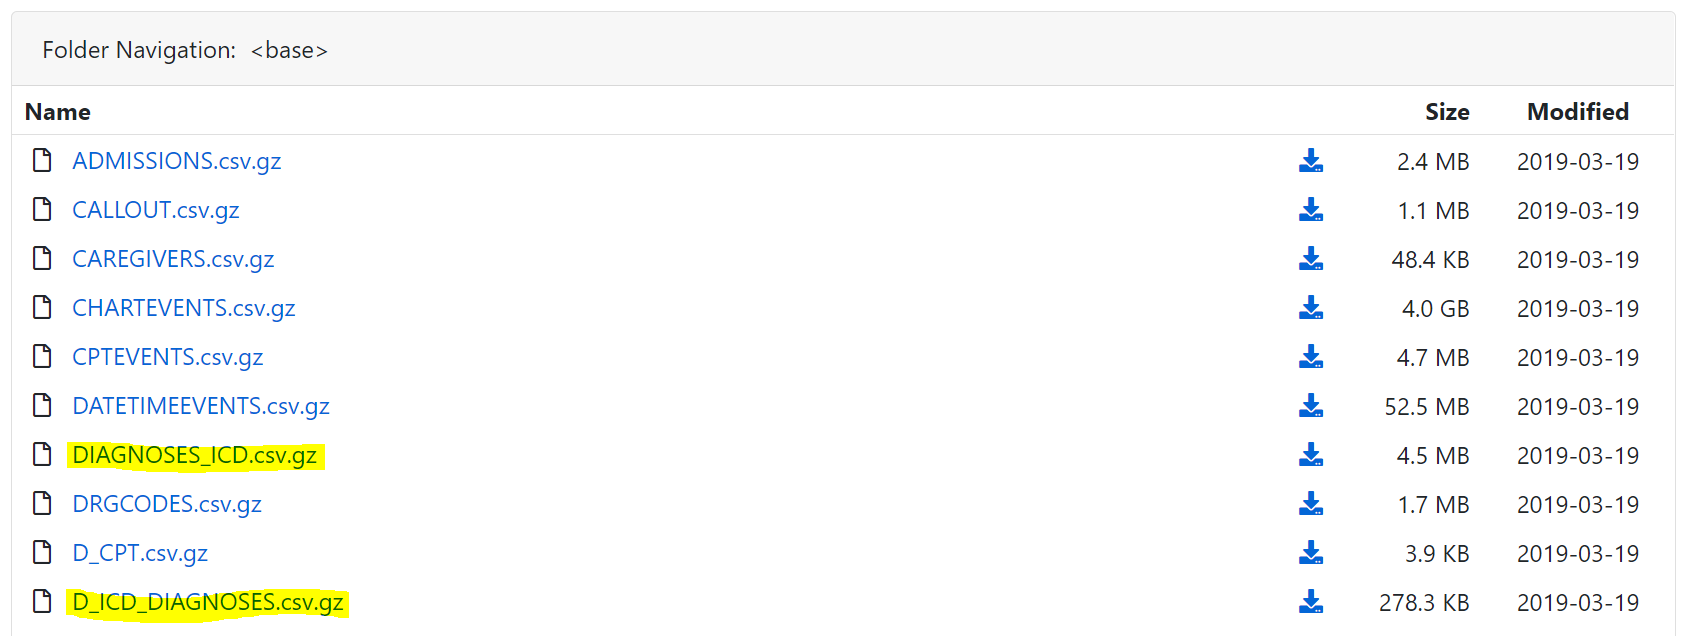
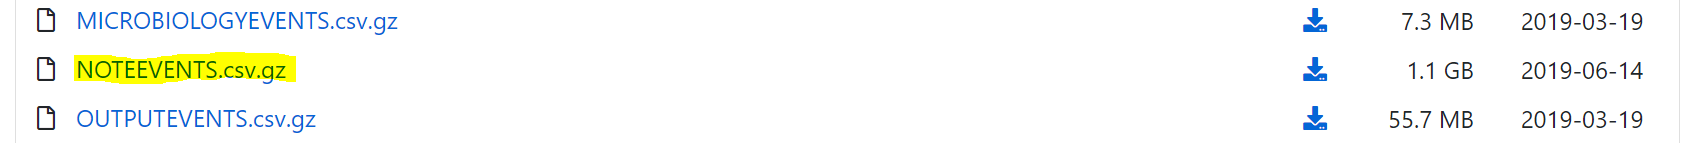

In order to be able to run this notebook, please download these datasets and save the .csv files in your working directory.

## Data description

MIMIC-III ("Medical Information Mart for Intensive Care") is a large, single-center database containing detailed
information on patients admitted to critical care units at a large tertiary care hospital. Included is, among others, data on vital signs, medications, laboratory measurements, observations and notes charted by care providers or diagnostic codes. [1]

MIMIC-III critical care database is a relational database consisting of 26 tables. Tables are linked by identifiers which usually have the suffix ‘ID’. For example, SUBJECT_ID refers to a unique patient, HADM_ID refers to a unique admission to the hospital, and ICUSTAY_ID refers to a unique admission to an intensive care unit.

Charted events such as notes, laboratory tests, and fluid balance are stored in a series of ‘events’ tables. For example the NOTEEVENTS table contains all clinical notes related to an event for a given patient.

Tables prefixed with ‘D_’ are dictionary tables and provide definitions for identifiers. For example, the D_ICD_DIAGNOSES table provides definitions for each ICD9 Code, which are used to indicate the diagnoses in the DIAGNOSES_ICD table.

For the purpose of this project, we will focus on the clinical notes, stored as text in NOTEEVENTS and corresponding diagnoses saved in DIAGNOSES_ICD and D_ICD_DIAGNOSES.

<img src="mimic_overview.PNG" style="width: 700px;"/>
Figure 1: Overview of the MIMIC-III critical care database. [1]

## Imports

First, let's make some basic imports...

In [14]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from minio import Minio
from pprint import pprint
from itertools import chain
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy import sparse
from joblib import dump

...and set some global options:

In [15]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', None)

## Define path, output files and load datasets

Below we define output file names for the created datasets and `knodle` matrices. $T$ matrix will be stored as `T_matrix.lib`, $Z$ matrix as `Z_train.lib`, `Z_test.lib`, `Z_val.lib` for train, test and validation data, respectively.

Store the downloaded datasets in the same directory as this notebook or indicate the your working directory in the following code snippet. Subsequently, load the csv files.

In [16]:
#path = "define_path"
#os.chdir(path)

Train_data_file = "Df_train.csv"
Test_data_file = "Df_test.csv"
Val_data_file = "Df_val.csv"

Z_output_train = "Z_train.lib"
Z_output_test = "Z_test.lib"
Z_output_val = "Z_val.lib"

T_output = "T_matrix.lib"

Notes = pd.read_csv("NOTEEVENTS.csv", low_memory=False)
Diagnoses = pd.read_csv("DIAGNOSES_ICD.csv", low_memory=False)
D_Diagnoses = pd.read_csv("D_ICD_DIAGNOSES.csv", low_memory=False)

## Data preview

Below you can find a preview of the considered data. The column of most interest is the "TEXT" column in the "Notes" dataframe. This column contains strings with clinical notes that are to be mapped to diagnoses using weak supervision. By joining "Notes" and "Diagnoses" by "SUBJECT_ID" and "HADM_ID", we will obtain a dataframe with notes and the corresponding diagnoses.

### Columns in NOTEEVENTS.csv

- **ROW_ID** - unique row identifier, ranging from 1 to 2083180 (#entries in the table).
- **SUBJECT_ID** - unique subject (patient) identifier. It is formated as an integer, ranging from 2 to 99999. NOTEEVENTS.csv contains 46146 unique SUBJECT_IDs, hence information about 46146 patients. For purposes of data protection, SUBJECT_IDs are printed as "0.0" in this preview. 
- **HADM_ID** - unique hospital admission identifier. Used to distinguish between multiple hospital admissions for the same patient. Again, for purposes of data protection, HADM_IDs are printed as "0.0" in this preview. 
- **CHARTDATE** - indicates when the observation was made with resolution down to the day. In order to de-identify the data, dates in the MIMIC III database were shifted into the future by a random offset for each individual patient in a consistent manner to preserve intervals, resulting in dates which occur sometime between the years 2100 and 2200.
- **CHARTTIME** - indicates when the observation was made with resolution down to the minute (not always available).
- **STORETIME** - provides information on the recording of the data element itself, i.e. the exact time (down to the minute) of the validation of the observation, before it was archieved into the patient medical record (not always available).
- **CATEGORY** - category of the given event. Possible values: "Discharge summary", "Echo", "ECG", "Nursing", "Physician", "Rehab Services", "Case Management", "Respiratory", "Nutrition", "General", "Social Work", "Pharmacy", "Consult", "Radiology", "Nursing/other".
- **DESCRIPTION** - description of the given clinical note. 3848 possible values, for instance "Report", "Addendum", "Nursing Transfer Note", "Family Meeting Note", "Progress Note"...
- **CGID** - unique identifier of the caregiver, who has recorded the data to the database.
- **ISERROR** - either "nan" or "1", indicating whether a physician has selected the 'Set as Error' button when entering the records to the database. This is the case for example when a note has been associated with the incorrect patient.
- **TEXT** - free text clinical notes stored as a string.

In [335]:
Notes.head(5)

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,0.0,0.0,2151-08-04,NaN,NaN,Discharge summary,Report,nan,nan,Admission Date: [**2151-7-16**] Dischar...
1,175,0.0,0.0,2118-06-14,NaN,NaN,Discharge summary,Report,nan,nan,Admission Date: [**2118-6-2**] Discharg...
2,176,0.0,0.0,2119-05-25,NaN,NaN,Discharge summary,Report,nan,nan,Admission Date: [**2119-5-4**] D...
3,177,0.0,0.0,2124-08-18,NaN,NaN,Discharge summary,Report,nan,nan,Admission Date: [**2124-7-21**] ...
4,178,0.0,0.0,2162-03-25,NaN,NaN,Discharge summary,Report,nan,nan,Admission Date: [**2162-3-3**] D...


An example of a clinical note from the NOTEEVENTS.csv table:

In [336]:
pprint(Notes.TEXT[0])

('Admission Date:  [**2151-7-16**]       Discharge Date:  [**2151-8-4**]\n'
 '\n'
 '\n'
 'Service:\n'
 'ADDENDUM:\n'
 '\n'
 'RADIOLOGIC STUDIES:  Radiologic studies also included a chest\n'
 'CT, which confirmed cavitary lesions in the left lung apex\n'
 'consistent with infectious process/tuberculosis.  This also\n'
 'moderate-sized left pleural effusion.\n'
 '\n'
 'HEAD CT:  Head CT showed no intracranial hemorrhage or mass\n'
 'effect, but old infarction consistent with past medical\n'
 'history.\n'
 '\n'
 'ABDOMINAL CT:  Abdominal CT showed lesions of\n'
 'T10 and sacrum most likely secondary to osteoporosis. These can\n'
 'be followed by repeat imaging as an outpatient.\n'
 '\n'
 '\n'
 '\n'
 '                            [**First Name8 (NamePattern2) **] [**First Name4 '
 '(NamePattern1) 1775**] [**Last Name (NamePattern1) **], M.D.  [**MD '
 'Number(1) 1776**]\n'
 '\n'
 'Dictated By:[**Hospital 1807**]\n'
 'MEDQUIST36\n'
 '\n'
 'D:  [**2151-8-5**]  12:11\n'
 'T:  [**2151-8-5**]  1

### Columns in DIAGNOSES_ICD.csv

- **ROW_ID, SUBJECT_ID, HADM_ID** - same as in NOTEEVENTS.csv
- **SEQ_NUM** - sequence identifier in the case of multiple diagnoses whithin a single hospital admission. Sequence 1 is the primary diagnosis.
- **ICD9_CODE** - International Classification of Diseases (ICD) codes for different diagnoses. ICD is a health care classification system, providing a system of diagnostic codes for classifying diseases, including nuanced classifications of a wide variety of signs, symptoms, abnormal findings, complaints, social circumstances, and external causes of injury or disease. This system is designed to map health conditions to corresponding generic categories together with specific variations, assigning for these a designated code, up to six characters long. Thus, major categories are designed to include a set of similar diseases. [2]

In [338]:
Diagnoses.head(5)

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,0.0,0.0,1.00,40301
1,1298,0.0,0.0,2.00,486
2,1299,0.0,0.0,3.00,58281
3,1300,0.0,0.0,4.00,5855
4,1301,0.0,0.0,5.00,4254


#### Columns in D_ICD_DIAGNOSES.csv

- **ROW_ID, ICD9_CODE** - same as in DIAGNOSES_ICD.csv
- **SHORT_TITLE** - short title of the corresponding diagnosis
- **LONG_TITLE** - long title of the corresponding diagnosis

D_ICD_DIAGNOSES.csv is not actually used for the analysis, but provides a nice illustration of how ICD-9 codes are linked to different diagnoses.

In [34]:
D_Diagnoses.head(5)

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


## CheXpert classes

Weak labels will be created based on `CheXpert` rules [3] (GitHub repository https://github.com/stanfordmlgroup/chexpert-labeler). `CheXpert` classifies radiology reports into 13 categories:

- Enlarged Cardiomediastinum
- Cardiomegaly
- Lung Opacity
- Lung Lesion
- Edema
- Consolidation
- Pneumonia
- Atelectasis
- Pneumothorax
- Pleural Effusion
- Pleural Other
- Fracture
- Support Devices

Since the MIMIC III data contains not only radiology notes and diagnoses, we first need to filter this dataset to contain only notes that could be correctly classified by `CheXpert`. For this, we use a mapping from `CheXpert` classes to ICD9 codes, that was obtained from the work by N. Nunes et. al [4] (GitHub repository https://github.com/nfrn/Multi-Modal-Classification-of-Radiology-Exams).

In [17]:
# ICD Codes Corresponding to CheXpert Classes

CheXpert_ICD = {'Enlarged Cardiomediastinum':['1642','1643','1648','1649','1971','2125','5193'],
                'Cardiomegaly':['4293'],
                'Lung Opacity':['79319'],
                'Lung Lesion':['51889','5172','5178','74860','74869','86120','86121','86122','86130','86131','86132','9471','79319'],
                'Edema':['5061','5184','7823'],
                'Consolidation':["5078",'51889','79319','486','481'],
                'Pneumonia':['01166','00322','01160','01161','01162','01163','01164','01165',
                             '0413','0551','0382','11505','11515','0730','48249','48281','48282',
                             '48283','4800','4801','4802','4803','4808','4809','481','4820','4821',
                             '4822','48230','48231','48232','48239','48240','48241','48242','48284','48289',
                             '4829','4830','4831','4838','4841','4843','4845',
                             '4846','4847','4848','485','486','4870','48801',
                             '48811','48881','51630','51630','51635','51636',
                             '51637','5171','7700','V066','99731','99732',
                             'V0382','V1261'],
                'Atelectasis':['7704','7705'],
                'Pneumothorax':['01170','01171','01172','01173',
                                '01174','01175','01176','5120',
                                '5121','51281','51282','51283',
                                '51289','8600','8601'],
                'Pleural Effusion':['51181','5119','5111'],
                'Pleural Other':["5110"],
                'Fracture':['80700','80710','8190','8191','V5427',
                            '80701','80702','80703','80704','80705',
                            '80706','80707','80708','80709','81103',
                            '81109','81110','80711','80712','80713',
                            '80714','80715','80716','80717','80718',
                            '80719','8072','8073','8074','81000',
                            '81001','81002','81003','81010','81011',
                            '81012','81013','81100','81101','81102',
                            '81103','73311','81111','81112','81113',
                            '81119','80500','80501','80502','80503',
                            '80504','80505','80506','80507','80508',
                            '80510','80511','80512','80513','80514',
                            '80515','80516','80517','80518','8052',
                            '8053','8054','8055','8058','8059','80600',
                            '80601','80602','80603','80604','80605',
                            '80606','80607','80608','80609','80610',
                            '80611','80612','80613','80614','80615',
                            '80616','80617','80618','80619','80620',
                            '80621','80622','80623','80624','806025',
                            '80626','80627','80628','80629','80630',
                            '80631','80632','80633','80634','80635',
                            '80636','80637','80638','80639','8064',
                            '8065','8068','8069'],
                'Support Devices':['V4321','V4500','V4509','99600','99609','9961','9962','99661','V5339','99672','99674']}


# List with CheXpert Classes

CheXpert_classes = list(CheXpert_ICD.keys())
CheXpert_classes = [x.lower().replace(" ", "_") for x in CheXpert_classes]

# Filter Diagnoses for CheXpert Classes only

Diagnoses_CheXpert = Diagnoses[Diagnoses["ICD9_CODE"].isin(list(chain.from_iterable(list(CheXpert_ICD.values()))))]

# Add Corresponding Notes

Diagnoses_CheXpert_Text = Diagnoses_CheXpert.merge(Notes[["SUBJECT_ID", "HADM_ID", "TEXT"]], on=["SUBJECT_ID","HADM_ID"], how="left")
Diagnoses_CheXpert_Text = Diagnoses_CheXpert_Text[["ICD9_CODE", "TEXT"]]
Diagnoses_CheXpert_Text = Diagnoses_CheXpert_Text.drop_duplicates().dropna()

The resulting dataframe Diagnoses_CheXpert_Text now only contains the ICD-9 codes and clinical notes of diagnoses that could be identified by `CheXpert`.

In [18]:
Diagnoses_CheXpert_Text.head(5)

,ICD9_CODE,TEXT
0,486,Admission Date: [**2141-9-18**] ...
1,486,PATIENT/TEST INFORMATION:\nIndication: Pericar...
2,486,Sinus rhythm\nRightward axis\nSince previous t...
3,486,"Chief Complaint: hypotension, altered mental ..."
4,486,"Chief Complaint: hypotension, altered mental ..."


## Statistics

Following section provides some basic statistics on the length of the text samples. By text length is meant the length of the string with the clinical note.

In [19]:
print("The dataset contains", Diagnoses_CheXpert_Text.shape[0], "samples.")

The dataset contains 1039009 samples.


In [333]:
text_lengths = Diagnoses_CheXpert_Text["TEXT"].str.len()
pd.DataFrame(text_lengths.describe()).rename(columns={"TEXT": "Text length statistics"})

,Text length statistics
count,1039009.00
mean,2152.86
std,2789.44
min,3.00
25%,673.00
50%,1276.00
75%,2160.00
max,55728.00


Text(0.5, 1.0, 'Text length distribution')

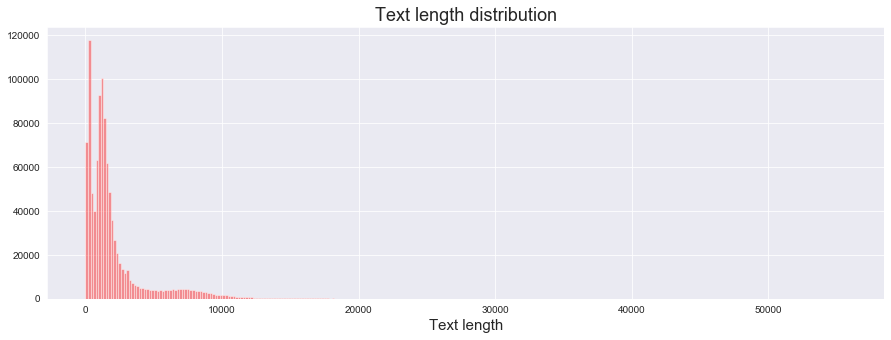

In [317]:
plt.figure(figsize=(15, 5))
sns.set_style("darkgrid")
sns.distplot(text_lengths, kde=False, color="r", bins=300)
plt.xlabel("Text length", fontsize=15)
plt.title("Text length distribution", fontsize=18)

## CheXpert rules

Weak labels will be created using keywords from the `CheXpert-labeler` (https://github.com/stanfordmlgroup/chexpert-labeler/tree/master/phrases/mention). These txt files contain synonyms and keywords for each class that will be used to derive the weak labels using string matching. The files are uploaded in the MinIO website (https://knodle.cc/minio/knodle/examples/labeler/chexpert/phrases/mention/) and downloaded through the following code snippet. Subsequently, the downloaded files with classes and keywords will be read to python as a dictionary called `mentions`. 

In [20]:
client = Minio("knodle.cc", secure=False)
CHEXPERT_DATA_DIR = os.path.join(os.getcwd(), "examples", "labeler", "chexpert")

MENTION_DATA_DIR = os.path.join(CHEXPERT_DATA_DIR, "phrases", "mention")
os.makedirs(MENTION_DATA_DIR, exist_ok=True)

CheXpert_files = [s + ".txt" for s in CheXpert_classes]

for file in tqdm(CheXpert_files):
    client.fget_object(
        bucket_name="knodle",
        object_name=os.path.join("examples/labeler/chexpert/phrases/mention/", file),
        file_path=os.path.join(MENTION_DATA_DIR, file),
    )

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  7.08it/s]


In [48]:
mentions = {}
for i in range(len(CheXpert_classes)):
    with open("".join([MENTION_DATA_DIR, "\\", CheXpert_classes[i], ".txt"])) as f:
        mentions[CheXpert_classes[i]] = [item.replace("\n", "") for item in f.readlines()]

In [49]:
pprint(mentions)

{'atelectasis': ['atelecta', 'collapse'],
 'cardiomegaly': ['cardiomegaly',
                  'the heart',
                  'heart size',
                  'cardiac enlargement',
                  'cardiac size',
                  'cardiac shadow',
                  'cardiac contour',
                  'cardiac silhouette',
                  'enlarged heart'],
 'consolidation': ['consolidat'],
 'edema': ['edema',
           'heart failure',
           'chf',
           'vascular congestion',
           'pulmonary congestion',
           'indistinctness',
           'vascular prominence'],
 'enlarged_cardiomediastinum': ['_mediastinum',
                                'cardiomediastinum',
                                'contour',
                                'mediastinal configuration',
                                'mediastinal silhouette',
                                'pericardial silhouette',
                                'cardiac silhouette and vascularity'],
 'fracture'

## Split data into train, test and validation set

We will now divide the available data into train, test and validations datasets. Test and validation data contain 1000 samples each and include gold labels (one-hot encoded, since one clinical note can correspond to multiple classes) obtained through the mapping from ICD9 codes to `CheXpert` classes defined earlier. All datasets will be saved in the working directory.

In [79]:
Df_train, Df_test = train_test_split(Diagnoses_CheXpert_Text, test_size=1000, random_state=1)

Df_train, Df_val = train_test_split(Df_train, test_size=1000, random_state=1)

In [92]:
Df_train = Df_train["TEXT"]
Df_train.to_csv(os.path.join(os.getcwd(), Train_data_file), header=True, index=False)

In [83]:
# Get gold labels for test set as one-hot encoding
for key in CheXpert_ICD.keys():
    col_name = key.lower().replace(" ", "_")
    Df_test[col_name] = Df_test.apply(lambda row: 1 if row["ICD9_CODE"] in CheXpert_ICD[key] else 0, axis = 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [85]:
Df_test = Df_test.drop(columns=["ICD9_CODE"])
Df_test.head(5)

,TEXT,enlarged_cardiomediastinum,cardiomegaly,lung_opacity,lung_lesion,edema,consolidation,pneumonia,atelectasis,pneumothorax,pleural_effusion,pleural_other,fracture,support_devices
727916,Today\ns Events:\n -Renal Ul...,0,0,0,0,0,0,1,0,0,0,0,0,0
325683,SOCIAL WORK\nSW consulted by RN for interventi...,0,0,0,0,0,0,0,0,0,0,0,1,0
78265,[**2105-12-26**] 3:26 PM\n ABDOMEN (WITH LAT D...,0,0,0,0,0,0,1,0,0,0,0,0,0
211865,"Respiratory Care: Pt is an 81 yo F, s/p arrest...",0,0,0,0,0,0,0,0,0,0,0,1,0
765452,[**2187-7-29**] 1:52 PM\n CHEST PORT. LINE PLA...,0,0,0,0,0,0,0,0,0,0,0,1,0


In [91]:
Df_test.to_csv(os.path.join(os.getcwd(), Test_data_file), header=True, index=False)

In [93]:
# Get gold labels for validation set as one-hot encoding
for key in CheXpert_ICD.keys():
    col_name = key.lower().replace(" ", "_")
    Df_val[col_name] = Df_val.apply(lambda row: 1 if row["ICD9_CODE"] in CheXpert_ICD[key] else 0, axis = 1)

In [94]:
Df_val = Df_val.drop(columns=["ICD9_CODE"])
Df_val.to_csv(os.path.join(os.getcwd(), Val_data_file), header=True, index=False)

## Knodle matrices

Now we can proceed to create and save the $T$ and $Z$ matrices. $T$ matrix will be stored as `T_matrix.lib`, $Z$ matrix will be stored as `Z_train.lib`, `Z_test.lib`, `Z_val.lib` as defined at the biginning of the tutorial.

### T matrix

The $T$ matrix is of shape (*number of rules* x *number of classes*) and contains the initial mapping from rules to the corresponding classes. 

$T_{jk}=1$ if rule $j$ is indicative of class $k$.

In [97]:
T_df = pd.concat([pd.Series(v, name=k).astype(str) for k, v in mentions.items()], axis = 1)
T_df = pd.get_dummies(T_df.stack()).sum(level=1).T

CheXpert_rules = list(T_df.index)

In [98]:
T_df.head(10)

,enlarged_cardiomediastinum,cardiomegaly,lung_opacity,lung_lesion,edema,consolidation,pneumonia,atelectasis,pneumothorax,pleural_effusion,pleural_other,fracture,support_devices
_line_,0,0,0,0,0,0,0,0,0,0,0,0,1
_mediastinum,1,0,0,0,0,0,0,0,0,0,0,0,0
air space disease,0,0,1,0,0,0,0,0,0,0,0,0,0
air-space disease,0,0,1,0,0,0,0,0,0,0,0,0,0
airspace disease,0,0,1,0,0,0,0,0,0,0,0,0,0
apparatus,0,0,0,0,0,0,0,0,0,0,0,0,1
arthroplast,0,0,0,0,0,0,0,0,0,0,0,0,1
atelecta,0,0,0,0,0,0,0,1,0,0,0,0,0
cannula,0,0,0,0,0,0,0,0,0,0,0,0,1
carcinoma,0,0,0,1,0,0,0,0,0,0,0,0,0


In [99]:
T_matrix = np.matrix(T_df)
T_matrix

matrix([[0, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

In [100]:
T_matrix.shape

(95, 13)

In [101]:
dump(T_matrix, T_output)

['T_matrix.lib']

### Z matrix

The $Z$ matrix is of shape (*number of samples* x *number of rules*) and contains information about which rule matches which sample. This matrix will be created for train, test and validation data separately.

$Z_{ij}=1$ if rule $j$ matches sample $i$.

In [110]:
Z_train_df = pd.DataFrame(Df_train)

for i in tqdm(CheXpert_rules):
    Z_train_df[i] = Z_train_df.apply(lambda row: 1 if (isinstance(row['TEXT'], str) and i in row['TEXT'].lower()) else 0, axis = 1)

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [34:47<00:00, 22.64s/it]


In [111]:
Z_train_df = Z_train_df[CheXpert_rules]
Z_train_df.head(10)

,_line_,_mediastinum,air space disease,air-space disease,airspace disease,apparatus,arthroplast,atelecta,cannula,carcinoma,...,scar,screw,support,the heart,tube,tumor,valve,vascular congestion,vascular prominence,wall thickening
306004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
822118,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
608681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
221182,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96043,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80566,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
287992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276702,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
760247,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1047109,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0


In [112]:
Z_matrix_train = np.matrix(Z_train_df)
Z_matrix_train

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [113]:
Z_matrix_train.shape

(1037009, 95)

In [114]:
dump(Z_matrix_train, Z_output_train)

['Z_train.lib']

In [115]:
Z_test_df = pd.DataFrame(Df_test)

for i in tqdm(CheXpert_rules):
    Z_test_df[i] = Z_test_df.apply(lambda row: 1 if (isinstance(row['TEXT'], str) and i in row['TEXT'].lower()) else 0, axis = 1)

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:02<00:00, 43.14it/s]


In [116]:
Z_test_df = Z_test_df[CheXpert_rules]
Z_matrix_test = np.matrix(Z_test_df)

In [117]:
Z_matrix_test.shape

(1013, 95)

In [118]:
dump(Z_matrix_test, Z_output_test)

['Z_test.lib']

In [120]:
Z_val_df = pd.DataFrame(Df_val)

for i in tqdm(CheXpert_rules):
    Z_val_df[i] = Z_val_df.apply(lambda row: 1 if (isinstance(row['TEXT'], str) and i in row['TEXT'].lower()) else 0, axis = 1)

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:02<00:00, 40.56it/s]


In [121]:
Z_val_df = Z_val_df[CheXpert_rules]
Z_matrix_val = np.matrix(Z_val_df)

In [122]:
Z_matrix_val.shape

(1000, 95)

In [123]:
dump(Z_matrix_val, Z_output_val)

['Z_val.lib']

#### Z matrix statistics

Following table shows how many samples match how many rules in the train data.

In [124]:
Z_rowsum = Z_matrix_train.sum(axis=1)
unique, counts = np.unique(np.array(Z_rowsum), return_counts=True)
pd.DataFrame({"# matched rules": unique, "# samples": counts}).style.hide_index()

# matched rules,# samples
0,278494
1,203774
2,155629
3,81732
4,56927
5,51626
6,49747
7,45149
8,37837
9,26599


Following table presents how many times a specific rule is matched in the train data.

In [125]:
Z_colsum = Z_matrix_train.sum(axis=0)
pd.DataFrame({"rule": CheXpert_rules, "# matches": np.array(Z_colsum).flatten()})

,rule,# matches
0,_line_,0
1,_mediastinum,0
2,air space disease,555
3,air-space disease,89
4,airspace disease,1796
5,apparatus,245
6,arthroplast,1046
7,atelecta,101540
8,cannula,39520
9,carcinoma,11007


## Finish

We have now created and saved T and Z matrices that can be further used within `knodle`!

## References

[1] Johnson, A. E., Pollard, T. J., Shen, L., Lehman, L. W., Feng, M., Ghassemi, M., Moody, B., Szolovits, P., Celi, L. A., & Mark, R. G. (2016). MIMIC-III, a freely accessible critical care database. Scientific data, 3, 160035. https://doi.org/10.1038/sdata.2016.35

[2] https://en.wikipedia.org/wiki/International_Classification_of_Diseases

[3] Irvin, J., Rajpurkar, P., Ko, M., Yu, Y., Ciurea-Ilcus, S., Chute, C., Marklund, H., Haghgoo, B., Ball, R., Shpanskaya, K., Seekins, J., Mong, D. A., Halabi, S. S., Sandberg, J. K., Jones, R., Larson, D. B., Langlotz, C. P., Patel, B. N., Lungren, M. P., & Ng, A. Y. (2019). CheXpert: A Large Chest Radiograph Dataset with Uncertainty Labels and Expert Comparison. Proceedings of the AAAI Conference on Artificial Intelligence, 33(01), 590-597. https://doi.org/10.1609/aaai.v33i01.3301590 


[4] Nunes N., Martins B., André da Silva N., Leite F., J. Silva M. (2019) A Multi-modal Deep Learning Method for Classifying Chest Radiology Exams. In: Moura Oliveira P., Novais P., Reis L. (eds) Progress in Artificial Intelligence. EPIA 2019. Lecture Notes in Computer Science, vol 11804. Springer, Cham. https://doi.org/10.1007/978-3-030-30241-2_28